# Detecting Fake News using an LTSM Neural Network with Word2Vec Embeddings

This report uses the fake and real news dataset from Kaggle (https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset). We will specifically focus on building a long term short memory (LSTM) neural network to predict whether or not a given piece of text is fake or true.

The appeal of using a LSTM RNN is due to its ability to remember information for a long period of time. This is useful when a given text can be several hundreds of words long. A traditional RNN may be useful for short pieces of text but they run into long term dependency issues with larger texts. LSTM are specifically designed to remember, this makes them ideal for the given task.

Lets load some package to analyse our data before we look at building a model

In [1]:
import os
import pandas as pd
import datetime as dt
from string import punctuation
import matplotlib.pyplot as plt
import nltk
import re
import gensim
import numpy as np

In [2]:
def GetData():
    df_list = []
    for name in ('Fake.csv','True.csv'):
        file = pd.read_csv(f'Data/{name}')
        file['label'] = name[0:4]
        df_list.append(file)
    
    file = pd.concat(df_list)
    
    return file

data = GetData()

In [3]:
data.head(10)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",Fake
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",Fake
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",Fake
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",Fake
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",Fake


The data consists of a title which is a heading of an article or piece of text, text which is the actual text body, subject manner, the date posted, and finally a label column which will be using as the target column for our prediction. We can check for any nulls in our data first before we try to extract additional information.

In [4]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

We have no nulls in our data, this is good, but what about texts that might have empty strings as '' or ' ' 

In [5]:
data[data['text'].isin(['', ' '])]

,title,text,subject,date,label
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017",Fake
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017",Fake
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017",Fake
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017",Fake
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017",Fake
...,...,...,...,...,...
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015",Fake
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015",Fake
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015",Fake
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015",Fake


There are 627 rows in our data with an empty text, rather than removing these rows we can simply concatenate title and text into new text column. The benefit of this is we'll retain some data and increase the number of words within our data without changing the context too much.

In [6]:
data['final_text'] = data['title'] + " " + data['text']

To help explore our data we will extract the following information:
    * Number of words
    * Number of unique words
    * Average word length
    * Number of uppercase / lowercase words
    * Number of punctuations used

In [7]:
# Calculate simply the number of words in a string
def NumberOfWords(string):
    if len(string) == 0:
        return 0
    
    return string.count(' ') + 1

# Calculate total number of unique words
def NumberOfUniqueWords(string):
    d = {}
    for i in string.lower().split(' '):
        if i not in d:
            d[i] = 1
    return len(d)

# Calculate the average word length of a given string
def AvgWordLength(string):
    if len(string) == 0:
        return 0
    
    total_length = NumberOfWords(string)
    number_of_letters = len(string) - total_length + 1
    
    return number_of_letters/total_length

# Calcualte number of uppercase words in a string
# Note we dont have a function for lowercase words as we can just do total number of words - uppercase words
def NumberOfUpperCaseWords(string):
    words = string.split()   
    return len([word for word in words if word.isupper()])

# Calculate total number of punctuation characters used
punctuation_set = set(punctuation)
def NumberOfPunctuations(string):
    return sum([1 for s in string if s in punctuation_set])

Before we apply some of these to the final_text column we will first remove urls, stopwords, and punctuations from final_text.

Stopwords are every day words that do not provide any additional meaning or context. Removing these words will leave us with a partition of text that still retains the meaning of a given sentence.

In [8]:
# Remove urls from text    
def RemoveURLS(string):
    return re.sub('https\S+','', string)

# Removing stopwords, these are words which add little to no information to a sentence. They can be removed and not affect the meaning of a given sentence.
# Examples of stopwords are the, is, has, etc. We can also go one step further and remove punctuations too.
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.update(punctuation_set)
# This tokenizer allows us to only extract words from a given string and ignore any punctuation used
tokenizer_for_words = nltk.tokenize.RegexpTokenizer(r'\w+')
def RemoveStopWordsAndPunctuation(string):
    output = []
    words = tokenizer_for_words.tokenize(string)
    for word in words:
        if word.strip().lower() not in stop_words and len(word) > 1:
            output.append(word)
    
    return ' '.join(output)

Before we remove punctuation we can compute the number of punctuations used in the text

In [9]:
data['number_of_punctuations'] = data['final_text'].apply(NumberOfPunctuations)

In [10]:
# Remove stop words and punctuation before other functions
data['final_text'] = data['final_text'].apply(RemoveURLS)
data['final_text'] = data['final_text'].apply(RemoveStopWordsAndPunctuation)

In [11]:
# Gather additional data from text
data['number_of_words'] = data['final_text'].apply(NumberOfWords)
data['number_of_unique_words'] = data['final_text'].apply(NumberOfUniqueWords)
data['avg_number_of_words'] = data['final_text'].apply(AvgWordLength)
data['number_of_uppercase_words'] = data['final_text'].apply(NumberOfUpperCaseWords)
data['number_of_lowercase_words'] = data['number_of_words'] - data['number_of_uppercase_words']

# Make final_text all lower case
data['final_text'] = data['final_text'].str.lower()

In [12]:
data.head(5)

,title,text,subject,date,label,final_text,number_of_punctuations,number_of_words,number_of_unique_words,avg_number_of_words,number_of_uppercase_words,number_of_lowercase_words
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake,donald trump sends embarrassing new year eve m...,122,302,178,5.798013,0,302
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake,drunk bragging trump staffer started russian c...,39,191,145,6.575916,2,189
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake,sheriff david clarke becomes internet joke thr...,148,369,237,5.997290,28,341
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake,trump obsessed even obama name coded website i...,120,285,187,5.887719,6,279
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake,pope francis called donald trump christmas spe...,40,219,164,5.922374,0,219


In [13]:
data_desc = data.describe().round(1)
data_desc

,number_of_punctuations,number_of_words,number_of_unique_words,avg_number_of_words,number_of_uppercase_words,number_of_lowercase_words
count,44898.0,44898.0,44898.0,44898.0,44898.0,44898.0
mean,56.8,245.6,168.1,6.3,6.1,239.5
std,64.5,207.2,118.7,0.4,8.5,202.8
min,0.0,0.0,1.0,0.0,0.0,0.0
25%,28.0,130.0,96.0,6.1,2.0,124.0
50%,47.0,218.0,156.0,6.3,4.0,213.0
75%,71.0,306.0,212.0,6.6,7.0,300.0
max,7295.0,5066.0,2335.0,18.7,313.0,4944.0


The first thing to notice is that there exists one or more datapoints that have 0 words. This is likely to be a text with only a url or punctuation. We can look for this and ultimately remove it.

In [14]:
data[data['number_of_words'] == 0]

,title,text,subject,date,label,final_text,number_of_punctuations,number_of_words,number_of_unique_words,avg_number_of_words,number_of_uppercase_words,number_of_lowercase_words
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,Fake,,38,0,1,0.0,0,0
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,Fake,,34,0,1,0.0,0,0
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,Fake,,52,0,1,0.0,0,0
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,Fake,,24,0,1,0.0,0,0
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,Fake,,24,0,1,0.0,0,0
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,Fake,,24,0,1,0.0,0,0
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,Fake,,24,0,1,0.0,0,0
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,Fake,,24,0,1,0.0,0,0
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,Fake,,24,0,1,0.0,0,0


Just as we thought, these are just urls that were removed from the final_text column. We can remove this from our data set easily

In [15]:
data = data[data['number_of_words'] > 0]

In [16]:
data_desc = data.describe().round(1)
data_desc

,number_of_punctuations,number_of_words,number_of_unique_words,avg_number_of_words,number_of_uppercase_words,number_of_lowercase_words
count,44889.0,44889.0,44889.0,44889.0,44889.0,44889.0
mean,56.8,245.6,168.1,6.3,6.1,239.5
std,64.5,207.2,118.7,0.4,8.5,202.8
min,0.0,4.0,4.0,4.3,0.0,0.0
25%,28.0,130.0,96.0,6.1,2.0,124.0
50%,47.0,218.0,156.0,6.3,4.0,213.0
75%,71.0,306.0,212.0,6.6,7.0,300.0
max,7295.0,5066.0,2335.0,18.7,313.0,4944.0


We notice theres a large difference between the 75% quantile and the maximum for all the columns above. This means there exists one or more texts that have a much higher corpus of words than the majority. When looking at the distribution these will appear right skewed with majority of the data lying in the left. 

**For visualisation purposes we will only subset the data to only include words with less than 2000 words**

In [17]:
subset_for_viz = data[data['number_of_words'] <= 2000]

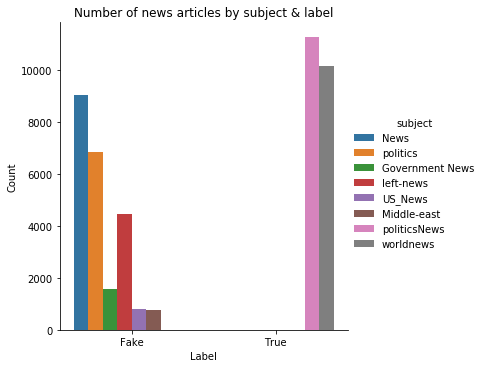

In [18]:
import seaborn as sns
sns.catplot(x = 'label', hue = 'subject', kind = 'count', data = data)
plt.title('Number of news articles by subject & label')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()

It is clear to see the subject column will not provide us with any additional insight in being able to identify a fake from a true news article. This will be ommitted from the model.

In [19]:
cols = ['number_of_words','number_of_unique_words','avg_number_of_words','number_of_uppercase_words','number_of_lowercase_words','number_of_punctuations']

def DistributionPlot(column):
    x1 = subset_for_viz[subset_for_viz['label'] == 'True'][column]
    x2 = subset_for_viz[subset_for_viz['label'] == 'Fake'][column]
    
    heading = ' '.join(column.split('_')).capitalize() + ' in text'
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (7,7))
    sns.distplot(x1 , color = "blue", ax = ax1, axlabel = '')
    ax1.set_title('True')
    sns.distplot(x2 , color = "green", ax = ax2, axlabel = '')
    ax2.set_title('Fake')
    fig.suptitle(heading)
    plt.show()

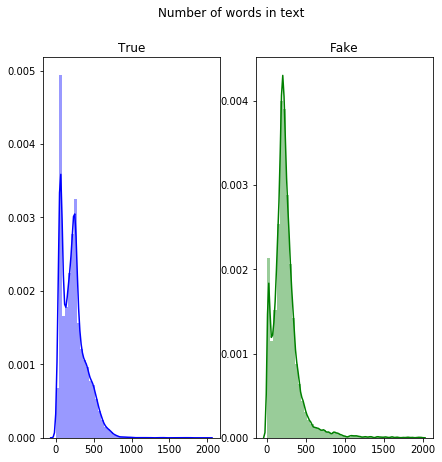

In [20]:
DistributionPlot('number_of_words')

The distribution for both fake and true news texts show that majority of texts are less than 500 words. We see peaks at around 250 for both. For true news texts there is a large peak at around 50 or so words, these could be tweets possibly.

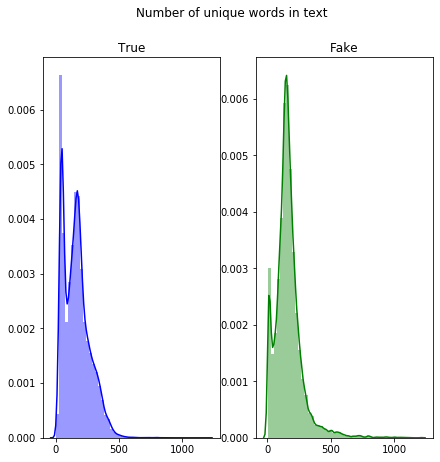

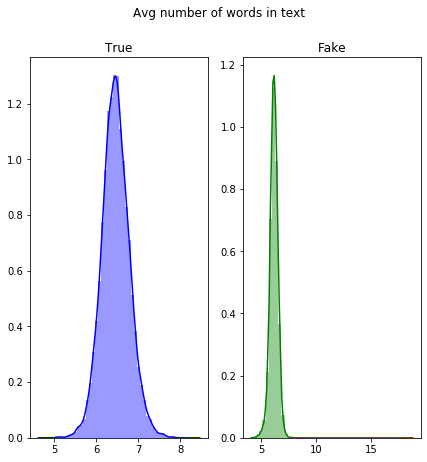

In [21]:
DistributionPlot('number_of_unique_words')
DistributionPlot('avg_number_of_words')

The unique words distribution is very similar to the number of words, expectedly. For average word however we see that news labeled as true has a very symmetrical distribution with average number of words by 6.5. This is similar to the news labeled as fake. The peak is around 6.5

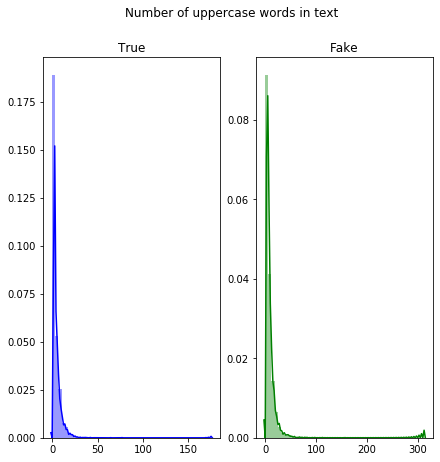

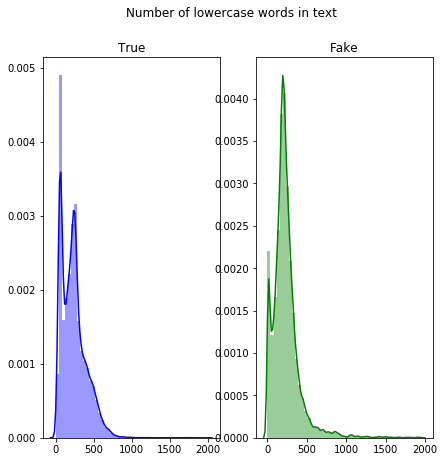

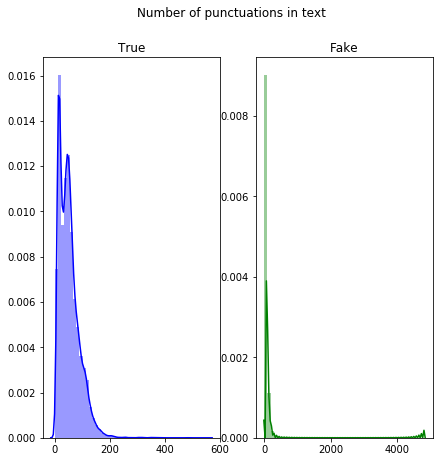

In [22]:
DistributionPlot('number_of_uppercase_words')
DistributionPlot('number_of_lowercase_words')
DistributionPlot('number_of_punctuations')

There are not many fully uppercased words in either fake or true new articles however from the x axis it is clear to see that fake news contain more uppercased words. This is why the distribution of lowercase words is practically identical to the distribution of number of words in a text. 

It is clear the number of punctuations used in true texts are higher than fake texts. One can argue the use of punctuation is a good indicator of someones ability to write concise articles which are likely to be truth.

**Preprocessing data for our LSTM RNN**

Before we train a model to predict whether or not a given text is fake or true we will be generating an embedding matrix which will provide us with a vector representation of our text. For ML models we are required to transform the text to numbers so it can be fed into a given model, however rather than just generating a simple
tokenized vector of our string (words to numbers) we will be using Word2Vec to create an embedding vector for all the words in our corpus (text).

Word2Vec is an extremely powerful and popular embedding tool that has the ability to capture context and similarities between words in a given corpus (text). It was created and published by a team of researchers led by Tomas Mikolov at Google.

Wikipedia link: https://en.wikipedia.org/wiki/Word2vec

In [23]:
def GetSentences(series):
    output = []
    for text in series:
        output.append(text.split())
    
    return output
        
# Each text is now represented as list of its words
sentences = GetSentences(data['final_text'])

In [24]:
sentences[0]

['donald',
 'trump',
 'sends',
 'embarrassing',
 'new',
 'year',
 'eve',
 'message',
 'disturbing',
 'donald',
 'trump',
 'wish',
 'americans',
 'happy',
 'new',
 'year',
 'leave',
 'instead',
 'give',
 'shout',
 'enemies',
 'haters',
 'dishonest',
 'fake',
 'news',
 'media',
 'former',
 'reality',
 'show',
 'star',
 'one',
 'job',
 'country',
 'rapidly',
 'grows',
 'stronger',
 'smarter',
 'want',
 'wish',
 'friends',
 'supporters',
 'enemies',
 'haters',
 'even',
 'dishonest',
 'fake',
 'news',
 'media',
 'happy',
 'healthy',
 'new',
 'year',
 'president',
 'angry',
 'pants',
 'tweeted',
 '2018',
 'great',
 'year',
 'america',
 'country',
 'rapidly',
 'grows',
 'stronger',
 'smarter',
 'want',
 'wish',
 'friends',
 'supporters',
 'enemies',
 'haters',
 'even',
 'dishonest',
 'fake',
 'news',
 'media',
 'happy',
 'healthy',
 'new',
 'year',
 '2018',
 'great',
 'year',
 'america',
 'donald',
 'trump',
 'realdonaldtrump',
 'december',
 '31',
 '2017trump',
 'tweet',
 'went',
 'welll',
 '

Sentences is a list which contains each article represented as a list of its words from the 'final_text' column in our data dataframe.

We will use the gensim package and the models.Word2Vec method to train a word2vec model with dimension (size) = 100. This will train and output each word as a 100 dimension vector which contain probabilities of 'closeness' to the other words around it. This 'closeness' will represent similar context and meanings to other words. We will use the default window size of 5, so that each worh will be trained against 5 words to the left and right of it. Another parameter is min_count which will only train words that appear at least 5 times in the entire corpus. Any words appearing less than 5 times are ignored and will have a vector of 0s. 

In [25]:
# Train the Word2Vec model on our sentences using a dimensional size of 100, window of 5, and a min_count of 5 (these are default).
wv_model = gensim.models.Word2Vec(sentences = sentences, size = 100, window = 5, min_count = 5)
print('%s words are now represented individually as a vector of size 100' % len(wv_model.wv.vocab))

46211 words are now represented individually as a vector of size 100


We should remember that we used min_count = 5 which has resulted in less words in our Word2vec model than the total number of unique words in our corpus. Decreasing min_count would result in more words being available in our Word2vec model. 

We can extract words with high similarities using the code below.

In [26]:
def GetMostSimilarWords(word):
    word = word.lower()
    return print('Most similar words to %s are: \n%s' %(word,wv_model.wv.most_similar(word)))

GetMostSimilarWords('twitter')
GetMostSimilarWords('write')
GetMostSimilarWords('male')

Most similar words to twitter are: 
[('2017twitter', 0.655044674873352), ('tweet', 0.6503632664680481), ('instagram', 0.6318762898445129), ('donaldjtrump', 0.6290934681892395), ('googlesyndication', 0.6273090839385986), ('tweets', 0.5873168706893921), ('lawnewz', 0.5854321122169495), ('xhamster', 0.581581711769104), ('dailymail', 0.5737782716751099), ('100percentfedup', 0.5704927444458008)]
Most similar words to write are: 
[('read', 0.6337066888809204), ('publish', 0.6289035081863403), ('writing', 0.5856404304504395), ('assure', 0.5848867893218994), ('learn', 0.5669413805007935), ('explain', 0.5628056526184082), ('submit', 0.5603357553482056), ('inform', 0.554432213306427), ('reading', 0.5540072917938232), ('spell', 0.552873969078064)]
Most similar words to male are: 
[('males', 0.7487133741378784), ('heterosexual', 0.6798708438873291), ('impregnate', 0.6648569703102112), ('folk', 0.6641701459884644), ('pasty', 0.6589733362197876), ('female', 0.6476230025291443), ('rednecks', 0.638971

**Lets build a model now**

In [27]:
# Keras tools for creating our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

Using TensorFlow backend.


In [28]:
# Transform each word to a number in our corpus to be fed into the NN
our_tokenizer = Tokenizer()
our_tokenizer.fit_on_texts(sentences)
tokenized_sentences = our_tokenizer.texts_to_sequences(sentences)

We've transformed all the words in the sentence list into a numerical number. This is so we can feed it into our model. However, each text in our data is of a different length and we need to have a fixed size of our input array. So, referring back to our distribution for number of words we see that a good input size would be roughly 800 words. The easiest way is to pad our tokenized_sentences into an array of 800 columns.

In [29]:
tokenized_sentences = pad_sequences(tokenized_sentences, maxlen = 800)
target = data['label'].values
target = [1 if x == 'True' else 0 for x in target]

What we have done here is restricted the number of words in the text to be only 800. If a text only has 500 words then the first 300 are padded with 0s
as the first tokenized_sentence index starts at 1. For texts with length more than 800, the first x - 800 are ignored and only the last 800 are retained. Our input array needs to be fixed
in a Neural Network that has a many (texts) to one (the output) model structure.

Furthermore, we have extracted the labels and turned into numericals with True = 1 and Fake = 0.

In [30]:
# Create our training and testing split
X_train, X_test, y_train, y_test = train_test_split(tokenized_sentences, target, test_size = 0.20, random_state = 0)

We've now split the data into a training and testing set. This is vital as we want to first train our data on some training set and then evaluate the model using a set of data the model has never seen. Our training set will be 70% of the data and the remaining 30% is for testing.

In [31]:
vocabulary_length = len(our_tokenizer.word_index) + 1

Although the total number of unique words in our data 118,638. We need to treat 0 (used for padded words) as a word. We can now create a matrix with each row representing the Word2vec vector of a unique word.

In [32]:
def GetEmbeddingMatrix(dictionary_of_words, word2vec_model, vocabulary_length, embedding_size = 100):
    # Define an empty matrix
    embedding_matrix = np.zeros((vocabulary_length, embedding_size))
    # For each word store the vector in the matrix using the mapping (position) of i
    for word, i in dictionary_of_words.items():
        if not word2vec_model.wv.__contains__(word):
            continue
        else:
            embedding_matrix[i] = word2vec_model.wv.__getitem__(word)
    return embedding_matrix

embedding_matrix = GetEmbeddingMatrix(our_tokenizer.word_index, wv_model, vocabulary_length)

**What is this embedding matrix we've created?**

This is a matrix where the index (row number) represents a single word in our corpus. The 100 columns contain the 100 length vectors from our word2vec model.
When a single number (representing a word) is used as an input, the model will take in the 100 length vector instead as it represents more data than just a single number.

**Building the actual model**

In [33]:
model = Sequential()
embedding_layer = Embedding(vocabulary_length, output_dim = 100, weights = [embedding_matrix], input_length = 800, trainable = False)

In the embedding layer we need to state the input dimension which is simply the number of unique words in our corpus. The output dimension is the length of each vector in this case we used 100 when training our word2vec model. The weights come from the embedding matrix we created above. In the input length is set at 800 as we padded our tokenized texts to be of length 800. Finally, this layer will be untrainable due to the fact we've already constructed a trainable word2vec model on our corpus.

In [34]:
model.add(embedding_layer)
model.add(LSTM(units = 128))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

We have an untrainable embedding layer as the first layer in the model. Then this is followed by the LSTM layer we mentioned at the very start. This is the layer which we use to incorporate a long term memory ability into to the model. Finally we use a dense layer which is essentially a simple neural network layer that has a single output unit.

In [35]:
history = model.fit(X_train, y_train, validation_split = 0.3, epochs = 10)

Train on 25137 samples, validate on 10774 samples
Epoch 1/10
25137/25137 [==============================] - 600s 24ms/step - loss: 0.1270 - acc: 0.9563 - val_loss: 0.1173 - val_acc: 0.9587
Epoch 2/10
25137/25137 [==============================] - 595s 24ms/step - loss: 0.0672 - acc: 0.9772 - val_loss: 0.0272 - val_acc: 0.9918
Epoch 3/10
25137/25137 [==============================] - 659s 26ms/step - loss: 0.0693 - acc: 0.9770 - val_loss: 0.0866 - val_acc: 0.9712
Epoch 4/10
25137/25137 [==============================] - 612s 24ms/step - loss: 0.0525 - acc: 0.9826 - val_loss: 0.0410 - val_acc: 0.9865
Epoch 5/10
25137/25137 [==============================] - 630s 25ms/step - loss: 0.0232 - acc: 0.9932 - val_loss: 0.0252 - val_acc: 0.9919
Epoch 6/10
25137/25137 [==============================] - 599s 24ms/step - loss: 0.0129 - acc: 0.9969 - val_loss: 0.0156 - val_acc: 0.9956
Epoch 7/10
25137/25137 [==============================] - 661s 26ms/step - loss: 0.0084 - acc: 0.9979 - val_loss: 0.

Our model has now been trained. 

**We used a small number of epochs (10) due to the time it take to train on a laptop. If we had access to better hardware we would surely increase**

Lets evaluate how the accuracy and the loss have changed throughout each epoch.

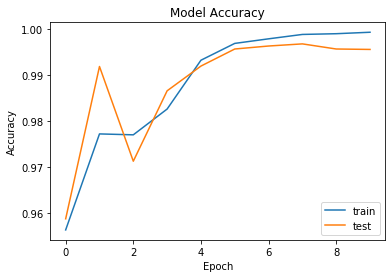

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc = 'lower right')
plt.show()

We see the accuracy of the model for both trainig and test set shoot up and down in the first 2 epochs but then gradually increase which is ideal. The only slight worrying thing is that the test accuracy slightly comes down about 7 epochs however because we've only used 10 epochs, which is quite small for a model, we can ignore this.

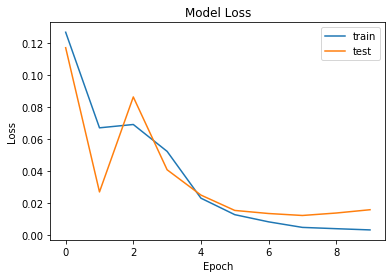

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc = 'upper right')
plt.show()

The loss for the model decreases steadily for both the training testing sets. However similar to the accuracy model, after 6 epochs we see the loss of the test set increases a bit. Again since we're using a small number of epochs we can be happy with this.

Lets use the X_test and y_test samples to look into the true negatives, true positives, false negatives, and false positives to evaluate the accuracy of the model we've built. For this first we'll calculate the predictions to X_test.

In [40]:
predictions = model.predict(X_test)
# For predictions with probability above 50% we will take as True and the rest as Fake
predictions = (predictions >= 0.5).astype(int)

In [54]:
confusion_report = confusion_matrix(y_test,predictions)
tn, fp, fn, tp = confusion_report.ravel()

print('True positive (Actual and predicted True): %s' % tp)
print('True negative (Actual and predicted False): %s' % tn)
print('False positive (Predicted True but actually False): %s' % fp)
print('False negative (Predicted False but actually True): %s' % fn)

True positive (Actual and predicted True): 4254
True negative (Actual and predicted False): 4689
False positive (Predicted True but actually False): 27
False negative (Predicted False but actually True): 8


In [58]:
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
precision = tp / (tp + fp)
false_omission_rate = fn / (fn + tn)

print('True positive rate is proportion of correctly classified results as True (Recall): %s' %round(tpr,4))
print('\nTrue negative rate is proportion of correctly classified results as False (Specificity): %s' %round(tnr,4))
print('\nFalse positive rate is proportion of incorrectly classified results as True: %s' %round(fpr,4))
print('\nFalse negative rate is proportion of incorrectly classified results as False: %s' %round(fnr,4))
print('\nPrecision is proportion of correctly classified True results from all predicted True results: %s' %round(precision,4))
print('\nFalse ommision rate is proportion of incorrectly classified False results from all predicted False results: %s' %round(false_omission_rate,4))

True positive rate is proportion of correctly classified results as True (Recall): 0.9981

True negative rate is proportion of correctly classified results as False (Specificity): 0.9943

False positive rate is proportion of incorrectly classified results as True: 0.0057

False negative rate is proportion of incorrectly classified results as False: 0.0019

Precision is proportion of correctly classified True results from all predicted True results: 0.9937

False ommision rate is proportion of incorrectly classified False results from all predicted False results: 0.0017


We have quite an accurate model as we have high recall and specificity whilst having low false positive / negative rates based on the testing set. It would seem that accuracies are extremely high and some may assume the model overfits however we can argue that we retained 20% of the data for testing purposes and only trained on 80% of the data.

**Improvements**
* We can take another dataset of fake and true news articles and see how the model performs on that
* Increase the testing data set to be 30%-40%, train the model again, and then evaluate the performance
* Use more data from 2019-2020 as technique to generate fake news articles likely have changed